# Analyse public Solvency 2 data of Dutch insurance undertakings

Welcome! In this tutorial we will use the public Solvency 2 data of all Dutch insurance undertakings and present it in one large DataFrame. In doing so, we are able to use some easy but powerful machine learning algorithms to analyze the data.

Solvency 2 data of individual insurance undertakings are published yearly by the Statistics department of DNB. The data represents the financial and solvency situation of each insurance undertaking at the end of each year. Because Solvency 2 came into effect in 2016, we currently have three years of data: ultimo 2016, ultimo 2017 and ultimo 2018. 

The publication of the data is in the form of an Excel file with a number of worksheets containing the aggregated data and the individual data. In this tutorial we will use the individual data.

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from src.data.make_dataframe import get_sheet

We use the data published on the DNB website in an Excel file

https://statistiek.dnb.nl/en/downloads/index.aspx#/?statistics_type=toezichtdata&theme=verzekeraars

In [2]:
xls = pd.ExcelFile("../data/Data individual insurers (year).xlsx")

The Excel file contains several worksheets with data. We want to combine all the data together in one DataFrame. To do that we need some data preparation and data cleaning for each worksheet. This is done by the following function.

## Creating one large vector per insurance undertaking

With the function above we can read a part of the Excel file and store it in a Pandas DataFrame. The following worksheets are contained in the Excel file published by DNB.

* Worksheet 14: balance sheet
* Worksheet 15: premiums - life
* Worksheet 16: premiums - nonlife
* Worksheet 17: technical provisions - 1
* Worksheet 18: technical provisions - 2
* Worksheet 19: transition and adjustments
* Worksheet 20: own funds
* Worksheet 21: solvency capital requirements - 1
* Worksheet 22: solvency capital requirements - 2
* Worksheet 23: minimum capital requirements
* Worksheet 24: additional information life
* Worksheet 25: additional information non-life
* Worksheet 26: additional information reinsurance

Let’s read the first worksheet with data and then append the other sheets to it. We shall not read the last three worksheets, because these contain the country specific reports. 

In [3]:
df = get_sheet(xls, 14)
for l in range(15, 24):
    df_temp = get_sheet(xls, l)
    df = df.join(df_temp, rsuffix = "_"+ str(l))

We take the data from the year 2018, and select all columns that have floating numbers in them.

In [4]:
df_18 = df.xs(datetime(2018,12,31), axis = 0, level = 1, drop_level = True)
df_18 = df_18[[df_18.columns[c] for c in range(len(df_18.columns)) if df_18.dtypes[c] == 'float64']]
df_18.fillna(0, inplace = True)

## Data analysis solvency ratio

We only consider insurance undertakings with the same book year and insurance undertakings that have reported every year. 

In [5]:
df = df.drop(['Bos Fruit Aardappelen Onderlinge verzekeringen BFAO U.A.'], level='relatienaam')
years = df.index.get_level_values(1).unique()
names = df.index.get_level_values(0).unique()
for i in names:
    if (((i,years[0]) in df.index) & ((i,years[1]) in df.index) & ((i,years[2]) in df.index)) == False: 
        df = df.drop(i,level='relatienaam')

We calculate the solvency ratio for each insurance undertaking in each year. Under Solvency 2, the solvency ratio is
the ratio of eligible own funds to required own funds. Required own funds, also referred to as the solvency capital
requirement (SCR), constitute a risk-based buffer, based on the actual risks on the balance sheet. 

In [6]:
SCR = pd.DataFrame(index = df.index)
SCR['assets'] = df['assets|total assets , solvency ii value']
SCR['ratio'] = (df['excess of assets over liabilities , solvency ii value'])/df['scr']
SCR['weight']=0
years = df.index.get_level_values(1).unique()
names = df.index.get_level_values(0).unique()
for i in names:
    for j in years:
        SCR.loc[(i,j),'weight'] = SCR.loc[(i,j),'assets']/sum(SCR.xs(j, level = 'periode')['assets'])

Besides the solvency ratio for each insurance undertaking we also calculate the weighted average solvency ratio of the whole insurance sector for each year.

In [7]:
ratio_t = pd.DataFrame(index=years)
ratio_t['ratio'] = 0
for j in years:
    ratio_t.loc[j,'ratio'] = sum(SCR.xs(j,level = 'periode')['ratio']*SCR.xs(j,level = 'periode')['weight'])

We are interested in the development of the solvency ratio over time. We plot the solvency ratio of an individual insurance undertaking - in this case AEGON Levensverzekering - and the weighted average solvency ratio. 

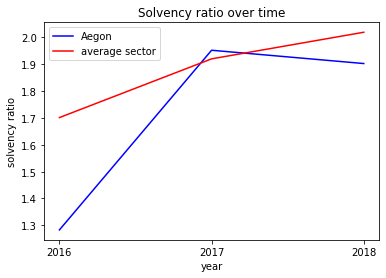

In [8]:
plt.plot(years.year, SCR.xs('AEGON Levensverzekering N.V.',level = 'relatienaam')['ratio'], color = 'blue',label = 'Aegon')
plt.plot(years.year,ratio_t['ratio'], color = 'red', label = 'average sector')
plt.xticks(np.arange(min(years.year), max(years.year)+1, 1))
plt.legend()
plt.title('Solvency ratio over time')
plt.xlabel('year')
plt.ylabel('solvency ratio')
plt.show()

## Finding the most similar insurance undertaking

Now let’s apply some algorithms to this data set. Suppose we want to know what insurance undertakings are similar with respect to their financial and solvency structure. To do that we can calculate the distances between all the data points of each insurance undertakings. An insurance undertaking with a low distance to another insurance undertaking might be similar to that undertaking.

If we divide each row by the total assets we do as if all insurance undertakings have equal size, and then the distances indicate similarity in financial and solvency structure (and not similarity in size).

In [9]:
X = df_18.div(df_18['assets|total assets , solvency ii value'], axis = 0)

The scikit-learn package provides numerous algorithms to do calculations with distances. Below we apply the NearestNeighbors algorithm to find the neighbors of each insurance undertaking. Then we get the distances and the indices of the data set and store them.

In [10]:
nbrs = NearestNeighbors(n_neighbors = 2, algorithm = 'brute').fit(X.values)

distances, indices = nbrs.kneighbors(X)

What are the nearest neighbors of the first ten insurance undertakings in the list?

In [11]:
for i in indices[0:10]:
    print(X.index[i[0]] + " --> " + X.index[i[1]])

ABN AMRO Captive N.V. --> Rabo Herverzekeringsmaatschappij N.V.
ABN AMRO Levensverzekering N.V. --> SRLEV N.V.
ABN AMRO Schadeverzekering N.V. --> Ansvar Verzekeringsmaatschappij N.V.
AEGON Levensverzekering N.V. --> Nationale-Nederlanden Levensverzekering Maatschappij N.V.
AEGON Schadeverzekering N.V. --> Nationale-Nederlanden Schadeverzekering Maatschappij N.V.
AEGON Spaarkas N.V. --> Robein Leven N.V.
ASR Aanvullende Ziektekostenverzekeringen N.V. --> Eno Aanvullende Verzekeringen N.V.
ASR Basis Ziektekostenverzekeringen N.V. --> Zilveren Kruis Zorgverzekeringen N.V. B+A
ASR Levensverzekering N.V. --> Achmea Pensioen- en Levensverzekeringen N.V.
ASR Schadeverzekering N.V. --> Veherex Schade N.V.


And with the shortest distance between two insurance undertakings we can find the two insurance undertakings that have the highest similarity in their structure.

In [12]:
min_list = np.where(distances[:,1] == distances[:,1].min())

list(X.index[min_list])

['DSW U.A., OWM Zorgverzekeraar',
 'Stad Holland Zorgverzekeraar Onderlinge Waarborgmaatschappij U.A.']

To find clusters of insurance undertakings who are similar to each other we increase the number of nearest neighbors and plot the results in a network diagram. The nodes represent the individual insurance undertakings and an edge between two insurance undertakings implies that they are nearest neigbors. 

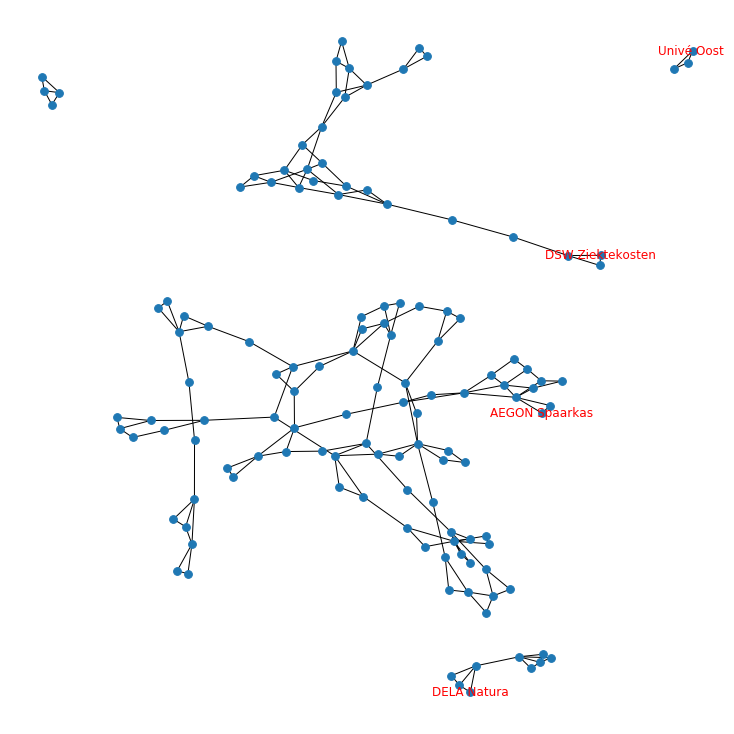

In [13]:
#Create adjacency matrix
G = nx.from_numpy_matrix(nbrs.kneighbors_graph(X.values, 3, mode='connectivity').toarray())
#Coordinates of insurance nodes 
pos = nx.spring_layout(G,seed=4)

plt.figure(1,figsize=(10,10)) 
#Create network
nx.draw(G, pos = pos, random_state = 0, node_size = 60)
#Print the names of some individual insurance undertakings
pos2 = {0: pos[5], 1: pos[26], 2: pos[28], 3: pos[112]}
labels2 = {0: X.index[5][:14], 1: X.index[26][:11], 2: X.index[28][:16], 3: X.index[112][:11]}
nx.draw_networkx_labels(G, pos2, labels = labels2, font_size = 12, font_color = 'red', font_family = 'sans-serif')
plt.show()

There is a small cluster with Univé entities. Moreover, there are two clear clusters of life insurance undertakings. Finally, health insurance undertakings are connected to each other. 

If you want to understand the financial performance it is of course handy to know which insurance undertakings are similar. A more general approach when comparing insurance undertakings is to cluster them into a small number of peer groups.

## Clustering of insurance undertakings

Can we cluster the insurance undertakings based on the 1272-dimensional data? To do this we apply the t-sne algorithm.

In [14]:
Y = TSNE(n_components = 2, perplexity = 5, verbose = 0, random_state = 0).fit_transform(X.values)

Subsequently, we plot the results.

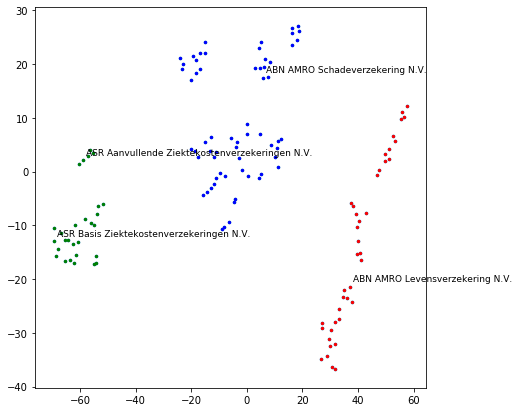

In [15]:
plt.figure(figsize = (7, 7))

plt.scatter(x = Y[:, 0], 
              y = Y[:, 1], 
              s = 7)

kmeans = KMeans(n_clusters = 3, random_state = 0, n_init  = 10).fit(Y)

#Give the clusters a different colour
for i in range(len(Y)):
    if kmeans.labels_[i] == 0:
        plt.scatter(x = Y[i,0], y = Y[i,1], s = 5, c = 'red')
    elif kmeans.labels_[i] == 1:
        plt.scatter(x = Y[i,0], y = Y[i,1], s = 5, c = 'green')
    elif kmeans.labels_[i] == 2:
        plt.scatter(x = Y[i,0], y = Y[i,1], s = 5, c = 'blue')
#Print the names of some individual insurance undertakings        
plt.text(Y[1,0]+1, Y[1,1]+1, X.index.get_level_values(0)[1], fontsize=9)
plt.text(Y[2,0]+1, Y[2,1]+1, X.index.get_level_values(0)[2], fontsize=9)
plt.text(Y[6,0]+1, Y[6,1]+1, X.index.get_level_values(0)[6], fontsize=9)
plt.text(Y[7,0]+1, Y[7,1]+1, X.index.get_level_values(0)[7], fontsize=9)
plt.show()

Depending on how you zoom in you see different clusters in this picture. The green cluster represents the health insurance undertakings (with more clusters within that set: those offering basic health insurance and other offering additional health insurances, or both). The blue cluster consists of (mostly) non-life insurance undertakings, and the red cluster consists of (mostly) life insurance undertakings. And both clusters can be divided into several more sub clusters. These clusters can be used in further analysis. For example, you could use these as peer groups of similar insurance undertakings.

## Clustering of features

Given that we have a 1272-dimensional vector of each insurance undertaking we might wish somehow to cluster the features in the data set. That is, we want to know which columns belong to each other and what columns are different.

An initial form of clustering were the different worksheets in the original Excel file. The data was clustered around the balance sheet, premiums, technical provisions, etc. But can we also find clusters within the total vector without any prior knowledge of the different worksheets?

A simple and effective way is to transpose the data matrix and feed it into the t-sne algorithm. That is, instead of assuming that each feature provides additional information about an insurance undertaking, we assume that each insurance undertaking provides additional information about a feature.

Let’s do this for only the balance sheet. In a balance sheet it is not immediately straightforward how the left side is related to the right side of the balance sheet, i.e. which assets are related to which liabilities. If you cluster all the data of the balance sheet then related items are clustered (irrespective of whether they are assets or liabilities).

In [ ]:
df = get_sheet(xls, 14)

Instead of the scaled values we now take whether or not a data point was reported or not, and then transpose the matrix.

In [ ]:
# scale data
X = (df != 0).T

Then we apply the t-sne algorithm. In this case with a lower perplexity. 

In [ ]:
Y = TSNE(n_components = 2, 
         perplexity = 1.0, 
         verbose = 0, 
         random_state = 0, 
         learning_rate = 20, 
         n_iter = 10000).fit_transform(X.values)

We plot the result with 15 identified clusters.

In [ ]:
plt.figure(figsize = (7, 7))

plt.scatter(x = Y[:, 0], 
              y = Y[:, 1], 
              s = 5)

kmeans = KMeans(n_clusters = 15, random_state = 0, n_init  = 10).fit(Y)

for i in range(len(kmeans.cluster_centers_)):
    
    plt.scatter(x = kmeans.cluster_centers_[i,0],
                   y = kmeans.cluster_centers_[i,1],
                   s = 1,
                   c = 'yellow')
    
    plt.annotate(str(i), 
                   xy = (kmeans.cluster_centers_[i, 0], kmeans.cluster_centers_[i, 1]), 
                   size = 13)

plt.show()

We see are large number of different clusters.

In a balance sheet it is not immediately straightforward how the left side is related to the right side of the balance sheet, i.e. which assets are related to which liabilities. If you cluster all the data of the balance sheet then related items are clustered (irrespective of whether they are assets or liabilities).

In [ ]:
for i in df.T.loc[kmeans.labels_ == 6].index:
    print(i)

So the assets held for index-linked and unit-linked contracts are in the same cluster as the technical provisions for index-linked and unit-linked items (and some other related items are found).

Besides clustering based on whether a data point was reported or not we now cluster the data related in their changes over time. We only consider insurance undertakings which report with the same book year and have reported every year. 

In [ ]:
df = get_sheet(xls, 14)
df = df.drop(['Bos Fruit Aardappelen Onderlinge verzekeringen BFAO U.A.'], level = 'relatienaam')
years = df.index.get_level_values(1).unique()
names = df.index.get_level_values(0).unique()
for name in names:
    if (((name,years[0]) in df.index) & ((name,years[1]) in df.index) & ((name,years[2]) in df.index)) == False: 
        df = df.drop(name, level = 'relatienaam')
X = df.T

Subsequently, we create a new DataFrame which consists of the changes over time and remove NaN too large numbers.

In [ ]:
a = pd.DataFrame((X.loc[:,pd.IndexSlice[:,years[1]]]-X.loc[:,pd.IndexSlice[:,years[0]]].values)/X.loc[:,pd.IndexSlice[:,years[0]]].values).rename(columns = {years[1]:'change1617'})
b = pd.DataFrame((X.loc[:,pd.IndexSlice[:,years[2]]]-X.loc[:,pd.IndexSlice[:,years[1]]].values)/X.loc[:,pd.IndexSlice[:,years[1]]].values).rename(columns = {years[2]:'change1718'})
X2 = a.join(b).sort_index(axis = 1)
X2.fillna(0, inplace = True)
X2[X2 >= np.finfo(np.float64).max]= 1000
X2[X2 == float('-inf')] = -1000
X2[X2 == float('+inf')] = 1000

Then we apply the t-sne algorithm. 

In [ ]:
Y = TSNE(n_components = 2, 
         perplexity = 1.0, 
         verbose = 0, 
         random_state = 0, 
         learning_rate = 20, 
         n_iter = 10000).fit_transform(X2.values)

We plot the results with 7 identified clusters

In [ ]:
plt.figure(figsize = (7, 7))

plt.scatter(x = Y[:, 0], 
              y = Y[:, 1], 
              s = 5)

kmeans = KMeans(n_clusters = 7, random_state = 0, n_init  = 10).fit(Y)

for i in range(len(kmeans.cluster_centers_)):
    #Plot center of each cluster
    plt.scatter(x = kmeans.cluster_centers_[i,0],
                   y = kmeans.cluster_centers_[i,1],
                   s = 1,
                   c = 'yellow')
    #Give number to each cluster
    plt.annotate(str(i), 
                   xy = (kmeans.cluster_centers_[i, 0], kmeans.cluster_centers_[i, 1]), 
                   size = 13)

plt.show()

Unfortunately, this does not yield very clear clusters. This is presumable because we do not have enough data since we only have two yearly differences available. Cluster 1 consists of 

In [ ]:
for i in df.T.loc[kmeans.labels_ == 5].index:
    print(i)

This cluster contains index-linked and unit-linked assets and liabilities.

In [ ]:
for i in df.T.loc[kmeans.labels_ == 6].index:
    print(i)

This cluster contains reinsurance recoverables.